In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy                         
scipy.sum = np.sum 
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo

# 1) Load scaled master table (from step 4)
scaled = pd.read_csv("data/clean/country_scaled_master.csv", index_col=None)
scaled = scaled.set_index("iso3")

# 2) Define your pillar columns again
demo_cols = ["total_population", "population_density", "urbanization_rate",
             "population_growth_pct", "literacy_rate_unesco", "life_expectancy"]
econ_cols = ["gdp_total_usd", "gdp_per_capita_ppp", "real_gdp_growth_pct",
             "inflation_pct_wb", "unemployment_rate"]
influ_cols = ["military_expenditure_pct_gdp", "military_expenditure_constusd",
              "wgi_gov_effectiveness", "Corruption_Perception_Index_2024_iso3"]

pillars = {
    "Demographic": demo_cols,
    "Economic"   : econ_cols,
    "Influence"  : influ_cols
}

In [2]:
def fa_diagnostics(df, cols):
    """Run Bartlett’s test, KMO, eigenvalues table."""
    X = df[cols].values
    chi2, p = calculate_bartlett_sphericity(X)
    kmo_all, kmo_model = calculate_kmo(X)
    print(f"Bartlett p‑value = {p:.5f}  (want < .05)")
    print(f"KMO overall     = {kmo_model:.3f}  (want > .6)")
    # eigenvalues from correlation matrix
    eig_vals, _ = np.linalg.eig(np.corrcoef(X.T))
    print("Eigenvalues:", np.round(sorted(eig_vals, reverse=True), 3))


In [3]:
for key, cols in pillars.items():
    print(f"\n— {key.upper()} pillar —")
    fa_diagnostics(scaled, cols)



— DEMOGRAPHIC pillar —
Bartlett p‑value = 0.00000  (want < .05)
KMO overall     = 0.671  (want > .6)
Eigenvalues: [2.173 1.077 0.998 0.826 0.555 0.371]

— ECONOMIC pillar —
Bartlett p‑value = 0.00310  (want < .05)
KMO overall     = 0.535  (want > .6)
Eigenvalues: [1.356 1.1   0.937 0.875 0.732]

— INFLUENCE pillar —
Bartlett p‑value = 0.00000  (want < .05)
KMO overall     = 0.509  (want > .6)
Eigenvalues: [1.651 1.026 0.938 0.384]


In [4]:
# 1) Configure number of factors per pillar
n_factors = {
    "Demographic": 2,   # Demographic
    "Economic": 2,      # Economic
    "Influence": 2      # Influence
}

# 2) Helper to fit FA, rotate, and return loadings & scores
def run_fa(df, cols, n, rotation="varimax"):
    fa = FactorAnalyzer(n_factors=n, rotation=rotation)
    fa.fit(df[cols])
    loadings = pd.DataFrame(
        fa.loadings_,
        index=cols,
        columns=[f"{cols[0][:4]}_f{i+1}" for i in range(n)]
    )
    scores = pd.DataFrame(
        fa.transform(df[cols]),
        columns=loadings.columns,
        index=df.index
    )
    return loadings, scores, fa.get_factor_variance()[1]  # [1] = prop var per factor

# 3) Run it for each pillar
fa_loadings = {}
fa_scores   = {}
fa_evr      = {}

for key, cols in pillars.items():
    load, scores, evr = run_fa(scaled, cols, n_factors[key])
    fa_loadings[key] = load
    fa_scores[key]   = scores
    fa_evr[key]      = evr
    print(f"\n— {key.upper()} Factor Loadings —")
    display(load.round(3))            # Jupyter display of the loadings
    print(f"Explained var per factor: {np.round(evr,3)}")


— DEMOGRAPHIC Factor Loadings —


c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,tota_f1,tota_f2
total_population,-0.000,-0.071
population_density,-0.004,0.262
urbanization_rate,0.319,0.621
population_growth_pct,-0.527,0.071
literacy_rate_unesco,0.664,0.244
life_expectancy,0.557,0.648


Explained var per factor: [0.188 0.157]

— ECONOMIC Factor Loadings —


c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,gdp__f1,gdp__f2
gdp_total_usd,0.268,0.025
gdp_per_capita_ppp,0.667,0.288
real_gdp_growth_pct,-0.007,0.275
inflation_pct_wb,0.061,0.405
unemployment_rate,0.282,-0.057


Explained var per factor: [0.12  0.065]

— INFLUENCE Factor Loadings —


c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\caded\anaconda3\envs\env1\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,mili_f1,mili_f2
military_expenditure_pct_gdp,0.008,0.412
military_expenditure_constusd,-0.147,-0.089
wgi_gov_effectiveness,0.816,-0.112
Corruption_Perception_Index_2024_iso3,0.758,0.072


Explained var per factor: [0.316 0.049]


In [5]:
# for key, df_scores in fa_scores.items():
#     df_scores.to_csv(f"data/clean/{key}_factor_scores.csv")

In [6]:
pillar_scores_fa = pd.DataFrame(index=scaled.index)
for key, evr in fa_evr.items():
    pillar_scores_fa[f"{key}_wsum"] = fa_scores[key].mul(evr, axis=1).sum(axis=1)

pillar_scores_fa["composite_fa"] = pillar_scores_fa.mean(axis=1)
pillar_scores_fa["rank_fa"]      = pillar_scores_fa["composite_fa"].rank(ascending=False, method="first")
# pillar_scores_fa.to_csv("data/clean/pillar_scores_fa.csv")

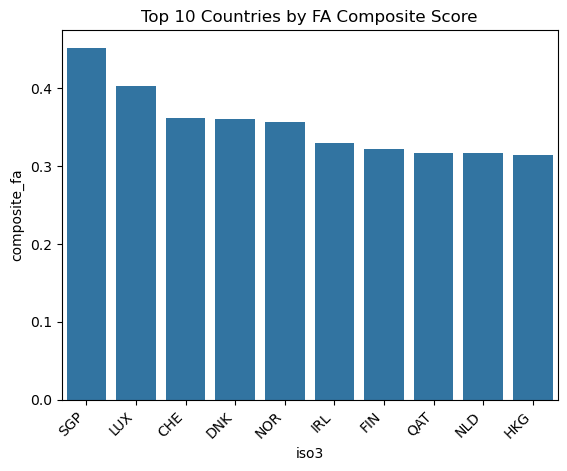

In [7]:
top10_fa = pillar_scores_fa.nlargest(10, "composite_fa")
sns.barplot(x=top10_fa.index, y=top10_fa["composite_fa"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Countries by FA Composite Score")
plt.show()

In [ ]:
# pd.DataFrame({
#     "iso3":       pillar_scores_fa.index,
#     "final_score": pillar_scores_fa["composite_fa"],
#     "rank":        pillar_scores_fa["composite_fa"].rank(ascending=False, method="first")
# }).to_csv("data/clean/final_fa_index.csv", index=False)